In [370]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

import h5py, os, sys

import pycbc
from pycbc.types.timeseries import TimeSeries
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter.resample import resample_to_delta_t
from pycbc.events import ThresholdCluster
from pycbc.filter import matched_filter, resample_to_delta_t, highpass_fir
from pycbc.vetoes import power_chisq
from pycbc.filter.matchedfilter import sigma
from pycbc.events.ranking import newsnr

from scipy.signal.windows import tukey

In [371]:
def figax(num=1, fsize=(20,5)):
    return plt.subplots(1,num, fsize)[1]

def multi_ts(TS , AX=None, Type='ts', titles=None, labels=None):
    
    if AX is None:
        fig, ax = plt.subplots(1, len(TS), figsize=(20, 5))
    else:
        ax = [AX for i in range(len(TS))]
        
    if labels is None:
        labels = [None for i in range(len(TS))]
        
    
    
    for i in range(len(TS)):
        
        if Type == 'ts': 
            ax[i].plot(TS[i].sample_times, TS[i], label=labels[i])
        else:
            fs = TS[i].to_frequencyseries()
            ax[i].plot(fs.sample_frequencies, abs(fs), label=labels[i])
            ax[i].set_xscale('log')
            ax[i].set_yscale('log')
            
            if titles is not None:
                ax[i].set_title(titles[i])
                
    if AX is not None:
        return ax
    
    return fig, ax
    

# Strain

bandpassed template

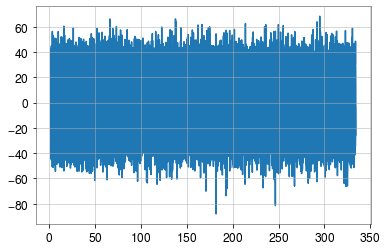

In [372]:
flow = 20
fhigh = 200
order = 512

strain = resample_to_delta_t(TimeSeries(np.array(h5py.File('\Dataset\Lstrain.hdf5', 'r')['strain']['Strain']), delta_t=1/4096), 1/512).time_slice(410,750)
strain = strain.highpass_fir(flow, order).lowpass_fir(fhigh, order)

strain.start_time = 0
strain.whiten(4,4).plot()

## Processing and Analysing Templates

I'll check the effect of bandpassing and windowing templates of different durations: $\Delta$t1 >> 20, $\Delta$t2 > 10, $\Delta$t3 > 5, $\Delta$t4 > 1 s

### Temp1 and temp2: dt1 >> 20, and dt2 > 10

Text(0.5, 0.98, 'Raw Templates')

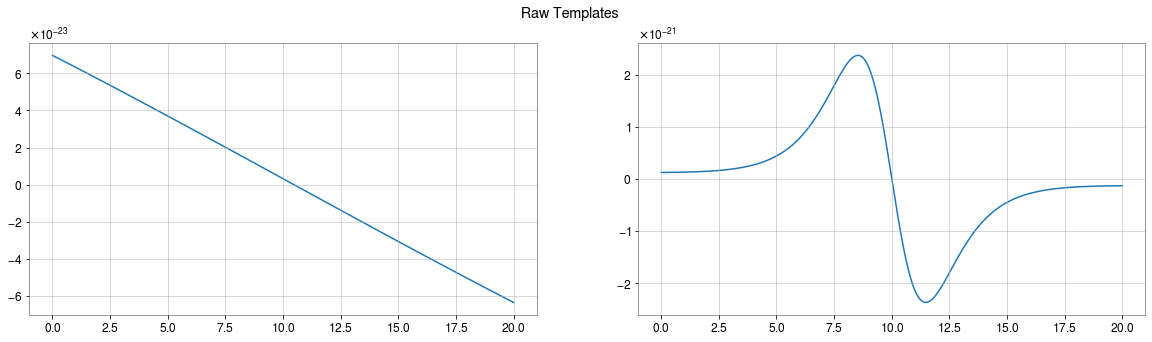

In [373]:
temp_hdf = h5py.File('\Dataset\linS.hdf5', 'r')

temp1 = TimeSeries(np.array(temp_hdf['Hc']['70']), delta_t=1/512)
temp2 = TimeSeries(np.array(temp_hdf['Hc']['60']), delta_t=1/512)

fig, ax = multi_ts([temp1, temp2], titles=['temp1', 'temp2'])

fig.suptitle('Raw Templates')

Text(0.5, 0.98, 'Frequencyseries of Templates')

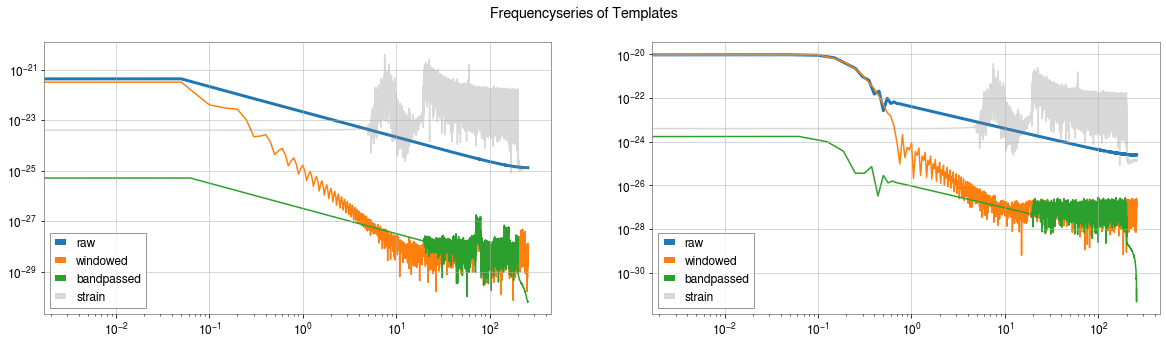

In [374]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

fstrain = strain.to_frequencyseries()

#temp1.resize(len(strain))

fs = temp1.to_frequencyseries()
ax[0].plot(fs.sample_frequencies, abs(fs), label='raw', linewidth=3)

fs = (temp1*tukey(len(temp1), 0.5)).to_frequencyseries()
ax[0].plot(fs.sample_frequencies, abs(fs), label='windowed')

fs = (temp1.highpass_fir(flow, order).lowpass_fir(fhigh, order)).to_frequencyseries()
ax[0].plot(fs.sample_frequencies, abs(fs), label='bandpassed')

fs = temp2.to_frequencyseries()
ax[1].plot(fs.sample_frequencies, abs(fs), label='raw', linewidth=3)

fs = (temp2*tukey(len(temp1), 0.5)).to_frequencyseries()
ax[1].plot(fs.sample_frequencies, abs(fs), label='windowed')

fs = (temp2.highpass_fir(flow, order).lowpass_fir(fhigh, order)).to_frequencyseries()
ax[1].plot(fs.sample_frequencies, abs(fs), label='bandpassed')


for i in range(2):
    ax[i].plot(fstrain.sample_frequencies, abs(fstrain), label='strain', color='gray', alpha=0.3)
    ax[i].legend()
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

    
plt.suptitle('Frequencyseries of Templates')


The blue curve is the raw template that has a sort of amplitude offset in frequency domain due to non-zero ends. Windowing and bandpassing templates fixes this offset and both produce similar results within the LIGO band. So, I can either use windowed or bandpasses templates for further analysis. 

Right now, I am choosing windowed templated as section 4 shows that windowed templates are less affected by length of templates

### Temp3 and temp4: dt > 2 and dt < 1 sTemp1

Text(0.5, 0.98, 'Raw Templates')

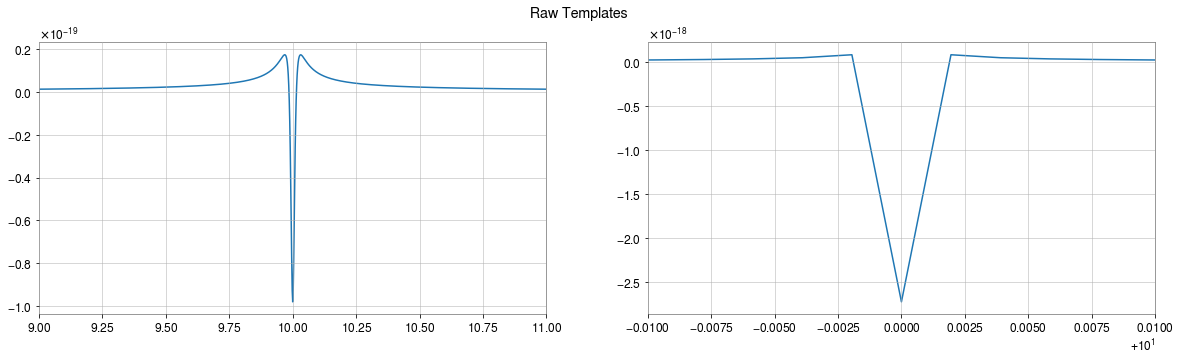

In [375]:
temp3 = TimeSeries(np.array(temp_hdf['Hp']['50']), delta_t=1/512)
temp4 = TimeSeries(np.array(temp_hdf['Hp']['42']), delta_t=1/512)

fig, ax = multi_ts([temp3, temp4], titles=['temp1', 'temp2'])

ax[0].set_xlim(9,11)
ax[1].set_xlim(9.99,10.01)

fig.suptitle('Raw Templates')

Text(0.5, 0.98, 'Frequencyseries of Templates')

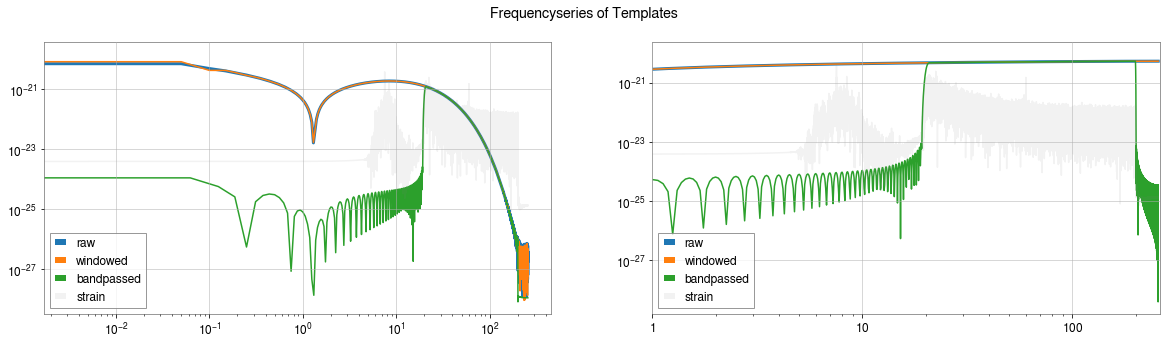

In [376]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

fstrain = strain.to_frequencyseries()

#temp1.resize(len(strain))

fs = temp3.to_frequencyseries()
ax[0].plot(fs.sample_frequencies, abs(fs), label='raw', linewidth=3)

fs = (temp3*tukey(len(temp1), 0.5)).to_frequencyseries()
ax[0].plot(fs.sample_frequencies, abs(fs), label='windowed')

fs = (temp3.highpass_fir(flow, order).lowpass_fir(fhigh, order)).to_frequencyseries()
ax[0].plot(fs.sample_frequencies, abs(fs), label='bandpassed')

fs = temp4.to_frequencyseries()
ax[1].plot(fs.sample_frequencies, abs(fs), label='raw', linewidth=3)

fs = (temp4*tukey(len(temp1), 0.5)).to_frequencyseries()
ax[1].plot(fs.sample_frequencies, abs(fs), label='windowed')

fs = (temp4.highpass_fir(flow, order).lowpass_fir(fhigh, order)).to_frequencyseries()
ax[1].plot(fs.sample_frequencies, abs(fs), label='bandpassed')


for i in range(2):
    ax[i].plot(fstrain.sample_frequencies, abs(fstrain), label='strain', color='gray', alpha=0.1)
    ax[i].legend()
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

ax[1].set_xlim(1,260)
    
plt.suptitle('Frequencyseries of Templates')

Bandpassing the signal changes the low frequency part of templates, but that this doesn't affect the SNR due to low frequency cut off. Windowing has no effect on these templates. The horizon distances for these templates seemed reasonable anyway.

## SNR Calculations

I'll determine the horizon distance for these 4 templates manually to check if they seem reasonable. The longer the duration, the lower the horizon distance should be. 

Method:
I'll find the regular SNR by
1. injecting the windowed signal at t=50 s
2. Finding PSD of resultant injected Strain. (for ~30 s long strain, I think a 20s long signal could slightly change SNR. That is why i find PSD after injecting)
3. resizing and shifting template (already windowed) and then finally the regular SNR
4. Dividing the templates by different horizon distances till I get a regular SNR ~ 8.

Aditionally, I also checked the new SNR (chi-squared reduced) with the template scaled to its horizon distance and check if it makes sense. Ideally, the reduced SNR should not change regualar SNR for the signal, but should only supress loud glitches. 


Below is a function for calculating SNR

In [413]:
def SNR(Temp, Strain, time=50, nbins=26, crop = 5, ret='reg'):
    
    
    strain = Strain.copy()
    temp = Temp.copy()
        
    ## if time is none, then template is not injected
    if time is not None:
        temp.start_time=time
        strain = strain.inject(temp)
        temp.start_time=0
    
    
    PSD = interpolate(strain.psd(4), strain.delta_f)
    PSD = inverse_spectrum_truncation(PSD, int(4 * strain.sample_rate), trunc_method='hann')
    #################################################
    
    temlen = temp.duration
    temp.resize(len(strain))
    temp = temp.cyclic_time_shift(strain.duration-temlen/2)
    
    snr = abs(matched_filter(temp, strain, psd=PSD, low_frequency_cutoff=flow, high_frequency_cutoff=fhigh))   
    
    if ret != 'reg':
        
        chisq = power_chisq(temp, strain, 26, PSD, low_frequency_cutoff=flow, high_frequency_cutoff=fhigh, return_bins=False)/(26*2-2)
        
        snr = TimeSeries(newsnr(snr, chisq), delta_t=1/512)
    return snr.crop(5,5)

In [555]:
temp1 = TimeSeries(np.array(temp_hdf['Hc']['70']), delta_t=1/512)
temp2 = TimeSeries(np.array(temp_hdf['Hc']['60']), delta_t=1/512)
temp3 = TimeSeries(np.array(temp_hdf['Hp']['50']), delta_t=1/512)
temp4 = TimeSeries(np.array(temp_hdf['Hp']['42']), delta_t=1/512)

temp1 = temp1.highpass_fir(flow, order).lowpass_fir(fhigh, order)
#temp2 = temp2.highpass_fir(flow, order).lowpass_fir(fhigh, order)
temp3 = temp3.highpass_fir(flow, order).lowpass_fir(fhigh, order)
#temp4 = temp4.highpass_fir(flow, order).lowpass_fir(fhigh, order)

#temp1 *= tukey(len(temp1), 0.5)
temp2 *= tukey(len(temp2), 0.5)
#temp3 *= tukey(len(temp2), 0.5)
temp4 *= tukey(len(temp2), 0.5)

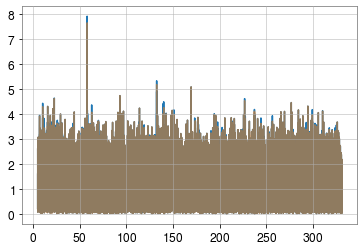

In [556]:
Dh1 = 0.00015# Mpc ( ~ 150 pc)

snr1 = SNR(temp1/Dh1, strain)
snr1.plot()

#plt.show()
snr1 = SNR(temp1/Dh1, strain, ret='new')
snr1.plot(alpha=0.5)

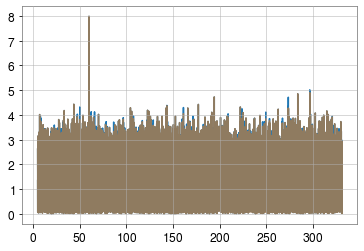

In [557]:
Dh2 = 0.00056 # Mpc ( ~ 560 pc)

snr2 = SNR(temp2/Dh2, strain)
snr2.plot()

snr2 = SNR(temp2/Dh2, strain, ret='new')
snr2.plot(alpha=0.5)

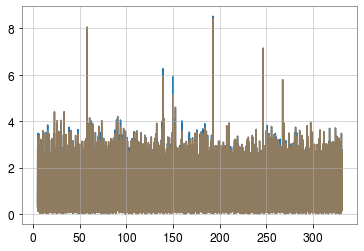

In [559]:
Dh3 = 50# Mpc ( ~ 63 Mpc)

snr3 = SNR(temp3/Dh3, strain)
snr3.plot()

snr3 = SNR(temp3/Dh3, strain, ret='new')
snr3.plot(alpha=0.5)



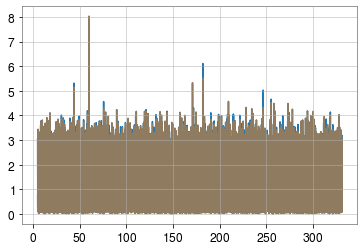

In [443]:
Dh4 = 3650# Mpc ( ~ 3650 Mpc)

snr4 = SNR(temp4/Dh4, strain)
snr4.plot()

snr4 = SNR(temp4/Dh4, strain, ret='new')
snr4.plot(alpha=0.5)

The horizon distance is very low for long signals, and high for short siganls.

The regular SNR matches well with chi-squared SNR as it is not supressing the signal. It is just supposed to supress loud glitches here. I have used pycbc.ranking.newsnr for this

## Whitening

The siganls are whitening well. I had to bandpass the already windowed templates here for calculations.

In [491]:
def whiten(Temp, Strain, Dh):
    
    temp = Temp.copy()
    
    temp = temp.highpass_fir(flow+10, order).lowpass_fir(fhigh-10, order)
    strain = Strain.copy()
    Len = temp.duration
    temp /= Dh
    
    temp.start_time = 50
    strain = strain.inject(temp)
    temp.start_time = 0
    
    
    PSD = interpolate(strain.psd(4), strain.delta_f)
    PSD = inverse_spectrum_truncation(PSD, int(4 * strain.sample_rate), trunc_method='hann')
    
    snr = SNR(temp, strain, time=None).time_slice(57, 59)
    
    dt = 50
    temp.resize(len(strain))
    
    temp /= sigma(temp, psd=PSD, low_frequency_cutoff=flow, high_frequency_cutoff=fhigh)


    temp = (temp.to_frequencyseries() * max(snr)).to_timeseries()
    wtemp = (temp.to_frequencyseries()/(PSD**0.5)).to_timeseries()
    wtemp.start_time = 50

    
    strain.whiten(4,4).highpass_fir(flow, order).lowpass_fir(fhigh, order).plot(linewidth=3)
    wtemp.highpass_fir(flow, order).lowpass_fir(fhigh, order).plot()
    
    plt.xlim(20,100)

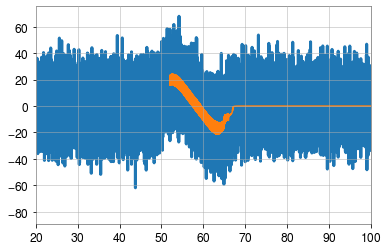

In [492]:
whiten(temp1, strain, Dh1/2)

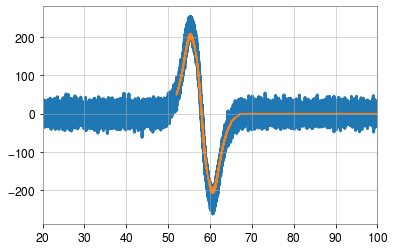

In [493]:
whiten(temp2, strain, Dh2/2)

(57.8, 58.25)

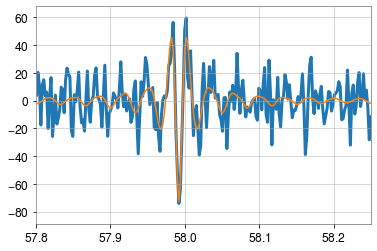

In [495]:
whiten(temp3, strain, Dh3/2)
plt.xlim(57.8, 58.25)

(57.9, 58.1)

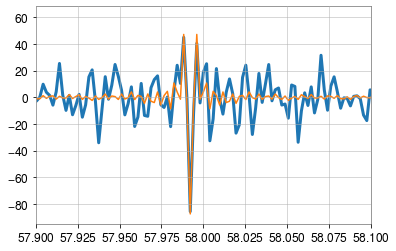

In [496]:
whiten(temp4, strain, Dh4)
plt.xlim(57.9, 58.1)

## Qtransform

(1e-25, 1e-21)

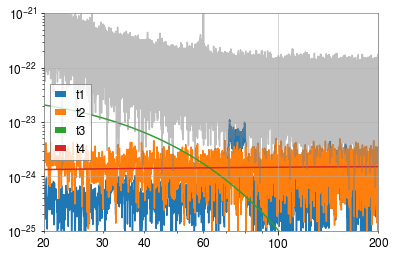

In [497]:
abs((temp1/Dh1).to_frequencyseries()).plot(label = 't1')
abs((temp2/Dh2).to_frequencyseries()).plot(label = 't2')
abs((temp3/Dh3).to_frequencyseries()).plot(label = 't3')
abs((temp4/Dh4).to_frequencyseries()).plot(label = 't4')

abs(strain.to_frequencyseries()).plot(c='gray', alpha=0.5)

plt.xlim(20, 200)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim(10**(-25), 10**(-21))

In [498]:
from gwpy.timeseries import TimeSeries as ts2
import gwpy


def Qtransform(Temp, Strain, Dh, time=60, frange=(20, 240) ,outseg=(40,80), qrange=(4,64), clim=None):
    
    temp = Temp.copy()
    strain = Strain.copy()
    Len = temp.duration
    temp /= Dh
    temp *= tukey(len(temp), 0.5)
    
    
    temp.start_time = time
    strain = strain.inject(temp)
    
    strain = ts2.from_pycbc(strain)
    
    
    hq2 = strain.q_transform(frange=frange, outseg=outseg, qrange=qrange)
    plot = hq2.plot()
    ax = plot.gca()
    ax.set_yscale('log')
    
    
    ax.colorbar(label="Normalised energy")
    

    if clim is not None:
        plot.colorbars[0].mappable.set_clim(clim[0],clim[1])
    
    return hq2


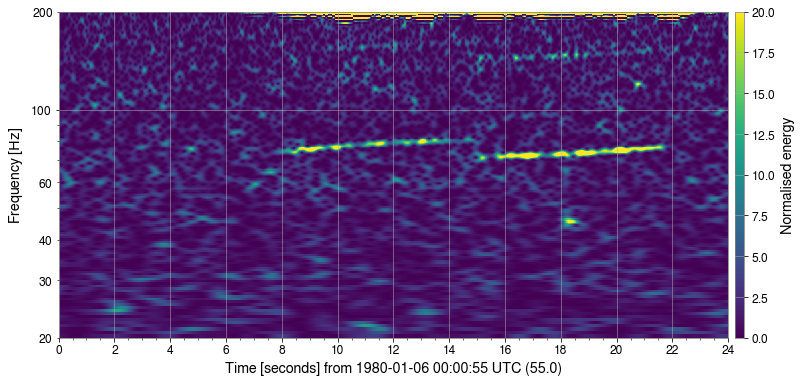

In [499]:
_= Qtransform(temp1, strain, Dh1/5, frange=(20, 200), qrange=(80, 90), outseg=(55, 79), clim=(0,20))


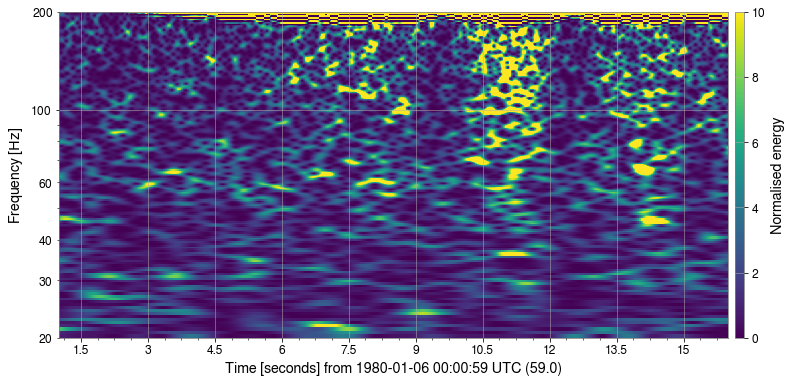

In [500]:
_= Qtransform(temp2, strain, Dh2/7, frange=(20, 200), qrange=(80, 90), outseg=(60, 75), clim=(0,10))

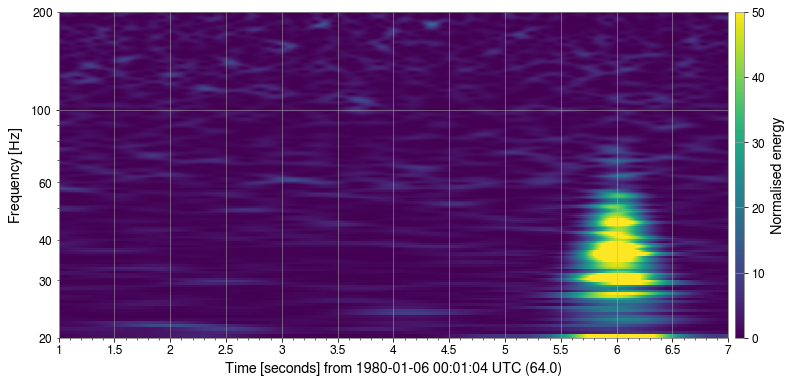

In [501]:
_= Qtransform(temp3, strain, Dh3/5, frange=(20, 200), qrange=(80, 90), outseg=(65, 71), clim=(0,50))

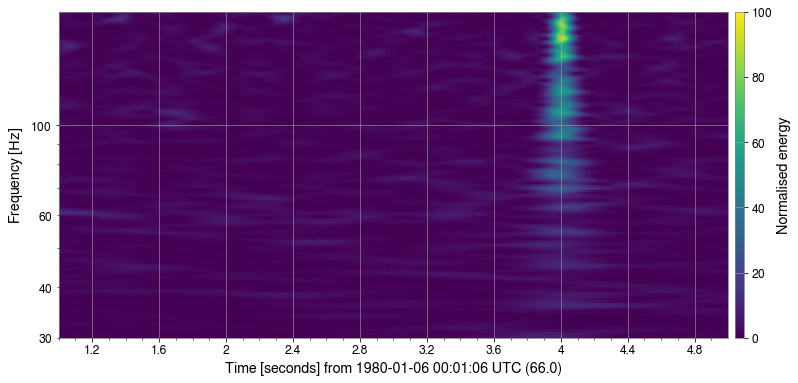

In [502]:
_= Qtransform(temp4, strain, Dh4/5, frange=(30, 190), qrange=(80, 90), outseg=(67, 71), clim=(0,100))

## Effect of Template Length

The templates have a problem that is not solved by either windowing or filtering. Changing the length of templates changes SNR. 

This might be reasonable for long duration templates as we might loose power by using 20 second templates. However, this is still a problem for short duration templates whose ends go to zero (specially with window) and so no power is lost by taking shorter templates.

I will first see how the snr changes with change in template length, then see how this effects the horizon distance, and see if it would affect trigger counts

Below, I show how snr changes with template length.
Below are the same templates where temp1 and temp2 have signals durations comparable to 20 s. I expect them to have different SNRs for different template 

In [576]:
temp1 = TimeSeries(np.array(temp_hdf['Hc']['70']), delta_t=1/512)
temp2 = TimeSeries(np.array(temp_hdf['Hc']['60']), delta_t=1/512)
temp3 = TimeSeries(np.array(temp_hdf['Hp']['50']), delta_t=1/512)
temp4 = TimeSeries(np.array(temp_hdf['Hp']['42']), delta_t=1/512)


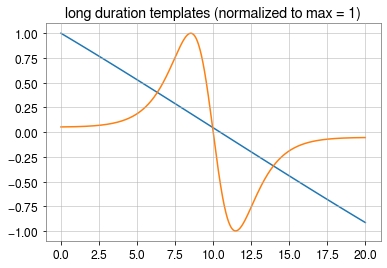

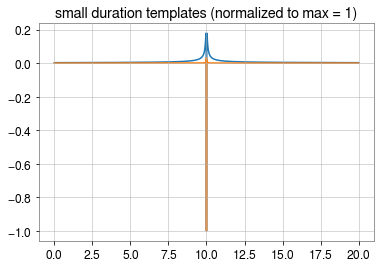

In [582]:
(temp1/max(abs(temp1))).plot()
(temp2/max(abs(temp2))).plot()
plt.title('long duration templates (normalized to max = 1)') 
plt.show()
(temp3/max(abs(temp3))).plot()
(temp4/max(abs(temp4))).plot()
plt.title('small duration templates (normalized to max = 1)') 
plt.show()

For the long duration templates, I understand how smaller template length would reduce its power and yeild a smaller SNR (top plot above)

For the small duration templates, the ends go to zero. So there should be no power loss if i change the template length upto 6 seconds. However, 
the snr changes for these templates too if I change the template length regardless of windowing or bandpassing.

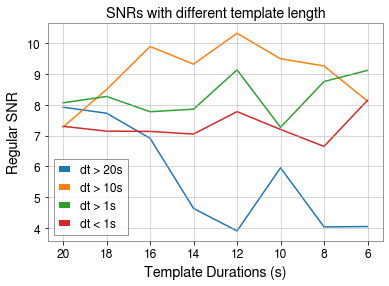

In [585]:
t1, t2, t3, t4 = [], [], [], []
for t in [0,1,2,3,4,5,6,7]:
    
    Temp1 = temp1.copy().time_slice(t, 20-t).highpass_fir(flow, order).lowpass_fir(fhigh, order)/Dh1
    Temp2 = temp2.copy().time_slice(t, 20-t).highpass_fir(flow, order).lowpass_fir(fhigh, order)/Dh2
    Temp3 = temp3.copy().time_slice(t, 20-t).highpass_fir(flow, order).lowpass_fir(fhigh, order)/Dh3
    Temp4 = temp4.copy().time_slice(t, 20-t).highpass_fir(flow, order).lowpass_fir(fhigh, order)/Dh4
    
    snr1 = max(SNR(Temp1, strain).time_slice(50,60))
    snr2 = max(SNR(Temp2, strain).time_slice(50,60))
    snr3 = max(SNR(Temp3, strain).time_slice(50,60))
    snr4 = max(SNR(Temp4, strain).time_slice(50,60))
    
    t1.append(snr1)
    t2.append(snr2)
    t3.append(snr3)
    t4.append(snr4)

plt.plot([0,1,2,3,4,5,6,7], t1, label='dt > 20s')
plt.plot([0,1,2,3,4,5,6,7], t2, label='dt > 10s')
plt.plot([0,1,2,3,4,5,6,7], t3, label='dt > 1s')
plt.plot([0,1,2,3,4,5,6,7], t4, label='dt < 1s')

plt.legend()
plt.title('SNRs with different template length')

plt.xticks([0,1,2,3,4,5,6,7], 2*(10-np.array([0,1,2,3,4,5,6,7])))
plt.xlabel('Template Durations (s)')
plt.ylabel('Regular SNR')

plt.show()
    

Temp1 (dt >> 20s) behaves as expected.

Temp2 had surprisingly higher SNR even with power loss ?

Temp3 and 4 both have randomly changing SNRs with different template lengths. time_slicing the ends should only remove zeros here and not effect the SNR too much.

Next I'll see how much this effects horizon distance

### Effect on Horizon Distance

I will get small duration templates with M = 10 Ms and find their horizon distance (strictly bound 7.95 < SNR < 8.05). I'll compare the windowed and bandpassed templates to see if any one of these solves this problem. 

(8.0, 12.0)

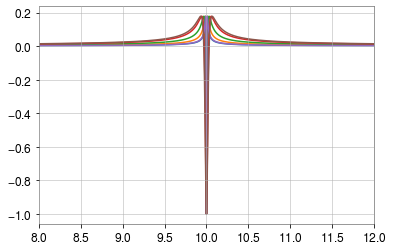

In [590]:
def get_temp(num, pol='Hp', fil='bandpass'):
    
    return TimeSeries(np.array(temp_hdf[pol][str(num)]), delta_t=1/512)

temp_list = np.arange(48, 54)

for i in temp_list:
               
    temp = get_temp(i)
    
    (temp/max(abs(temp))).plot()


plt.xlim(8,12)

In [623]:
def horizon(temp, strain, lims = (7.95, 8.05)):
    
    tslice = (50,60)
    i = 0 # initial distance (source and detector)
    itt = 2 # will itterate as 10**(itt) or 1/10**(itt)

    # check if Dh = 6 (1 Mpc) is alreadt the horizon distance for this template
    snr = max(SNR(temp, strain).time_slice(tslice[0], tslice[1]))
    
    if snr > lims[0] and snr < lims[1]:
        return i
    
    # if snr is lower than 7.5, then keep reducing the lumin Distance by 10**2. When the snr crosses 8.5, then lower the itterator by half.
    # At that point, function will reduce the Lumin Distance by 10**1 instead of 10**2. When SNR is finally between 7.5 and 8.5, the loop stops.
    if snr < lims[0]:
        keep = True
        while keep:
            i -= itt
        
            snr = max(SNR(temp/10**i, strain).time_slice(tslice[0], tslice[1]))
        
            if snr > lims[1]:
                i += itt
                itt /= 2
        
            if snr > lims[0] and snr < lims[1]:
                keep = False
            
                return i
    
    # same if the snr is more than 8.5. Here the Lumin Distance is increased instead of decreased.
    if snr > lims[1]:
        keep = True
        while keep:
            i += itt
        
            snr = max(SNR(temp/10**i, strain).time_slice(tslice[0], tslice[1]))
        
            if snr < lims[0]:
                i -= itt
                itt /= 2
        
            if snr > lims[0] and snr < lims[1]:
                keep = False
            
                return i

 89%|████████████████████████████████████████     | 8/9 [01:16<00:09,  9.52s/it]


Text(0, 0.5, 'Dh [Mpc]')

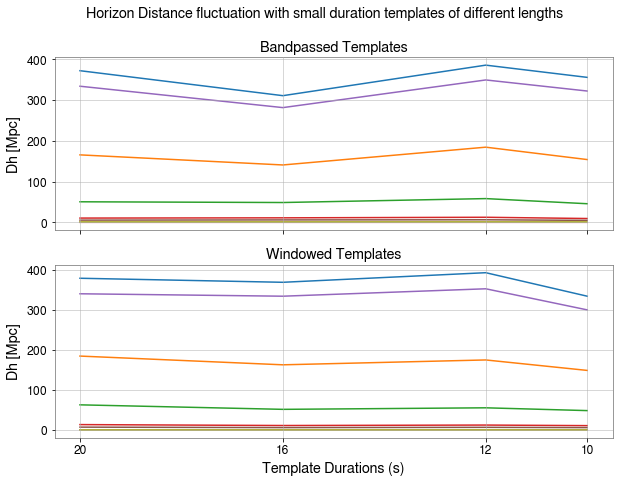

In [593]:
from tqdm import tqdm
temp_list = np.arange(48, 57)

DH_band = []
DH_win = []

fig, ax = plt.subplots(2, figsize=(10,7), sharex=True)

for i, z in zip(temp_list, tqdm(range(len(temp_list)))):
               
    temp = get_temp(i)
   
    times = [0,2,4,5]
    
    Dh_band = []
    Dh_win = []

    
    for t in times:
        
        Temp = temp.copy().time_slice(t, 20-t).highpass_fir(flow, order).lowpass_fir(fhigh, order)
        Dh_band.append(10**horizon(Temp, strain))
        
        Temp = temp.copy().time_slice(t, 20-t)
        Temp *= tukey(len(Temp), 0.5)
        Dh_win.append(10**horizon(Temp, strain))
        
        
    DH_band.append(Dh_band)
    DH_win.append(Dh_win)
    
    ax[0].plot(times, Dh_band)
    ax[1].plot(times, Dh_win)
    
ax[0].set_title('Bandpassed Templates')
ax[1].set_title('Windowed Templates')

plt.suptitle('Horizon Distance fluctuation with small duration templates of different lengths')
ax[1].set_xticks([0,2,4,5], 2*(10-np.array([0,2,4,5])))

ax[1].set_xlabel('Template Durations (s)')
ax[0].set_ylabel('Dh [Mpc]')
ax[1].set_ylabel('Dh [Mpc]')

In [594]:
DH_win[0]

[378.551524925863, 368.4734918695216, 392.4189758484536, 333.76246942920386]

To see how much the the horizon distance is effected, I check the percentage error between max and min distance. 

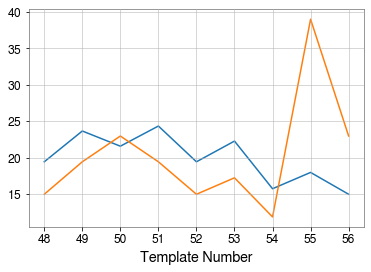

In [575]:
error_band = []
error_win = []
for i in range(len(DH_band)):

    err = (max(DH_band[i])-min(DH_band[i]))/max(DH_band[i])*100
    error_band.append(err)
    
    err = (max(DH_win[i])-min(DH_win[i]))/max(DH_win[i])*100
    error_win.append(err)
        
        
plt.plot(error_band)
plt.plot(error_win)
plt.xticks(np.arange(9), temp_list)
plt.xlabel('Template Number')
plt.show()

With band passes signals, many templates have severe fluctuations in horizon distance with the template length is changes (for small duration templates). The resultant percentage error in Horizon Distance is ~ 25%.xlabel('Template Durations (s)')

### Effect on Trigger Count

This issue happens either due to injection process or during snr calculation.

I will pick very glitchy part of strain, and see if those glitches have different SNRs with templates of different lengths.

In [631]:
strain2 = resample_to_delta_t(TimeSeries(np.array(h5py.File('\Dataset\Lstrain.hdf5', 'r')['strain']['Strain']), delta_t=1/4096), 1/512)

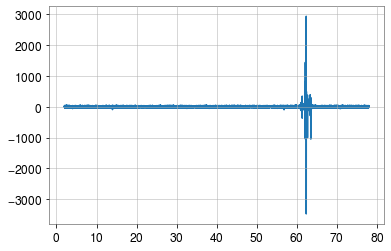

In [632]:
strain2 = strain2.time_slice(256, 340)

strain2 = strain2.highpass_fir(flow, order).lowpass_fir(fhigh, order)
strain2.start_time=0

strain2.whiten(4,4).plot()


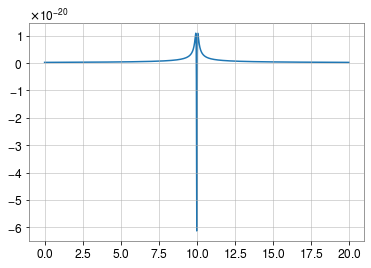

In [633]:
temp = get_temp(53)
temp.plot()

6.030661417569431
6.030596238351221
6.030580313748172
6.030591642879533


(3, 8.24893978873527)

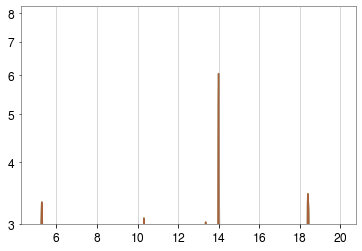

In [640]:
times = [0,2,4,5]
    
Dh_band = []
Dh_win = []

    
for t in times:
        
    Temp = temp.copy().time_slice(t, 20-t).highpass_fir(flow, order).lowpass_fir(fhigh, order)
        
    snr = SNR(Temp, strain2, time=None).time_slice(5,20)
    
    print(max(snr))
    snr.plot(alpha=0.5)
        
    #Temp = temp.copy().time_slice(t, 20-t)
    #Temp *= tukey(len(Temp), 0.5)
plt.yscale('log')
plt.ylim(bottom=3)
        

12.18540390899779
12.185394506294312
12.185406457222465
12.185394277832422


(3, 18.805721382909596)

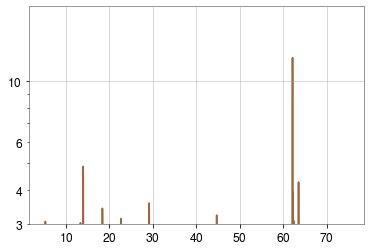

In [641]:
times = [0,2,4,5]
    
Dh_band = []
Dh_win = []

    
for t in times:
        
    Temp = temp.copy().time_slice(t, 20-t).highpass_fir(flow, order).lowpass_fir(fhigh, order)
        
    snr = SNR(Temp, strain2, time=None, ret='new')
    
    print(max(snr))
    snr.plot(alpha=0.5)
        
    #Temp = temp.copy().time_slice(t, 20-t)
    #Temp *= tukey(len(Temp), 0.5)
plt.yscale('log')
plt.ylim(bottom=3)
        

This template length issue doesn't effect triggers for small duration signals with both regular and new snr. This means that the template length issue is definately from the injections. 

Below is an example of mid duration template

Below is a mid duration template that looses some power with templates < 20 s duration. The resultant variation in SNR is very low. The horizon distance is kind of low (1.5 kpc). Should I increase its template length to 40 s?

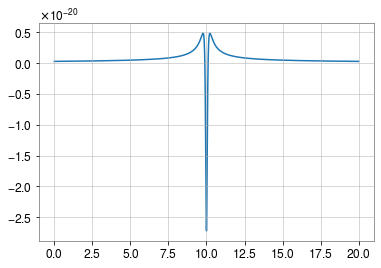

horizon distance  =  0.0018768842935762188  Mpc
3.279834969459917
3.3339938187202742
3.5144733454424877
3.498393521192982


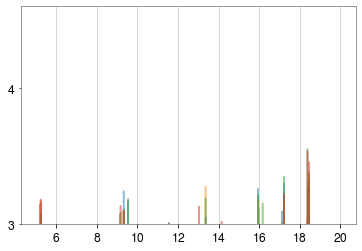

2.365901479369236
2.298137314884057
2.434929973867525
2.4305797147838324


(3, 3.3303048208565262)

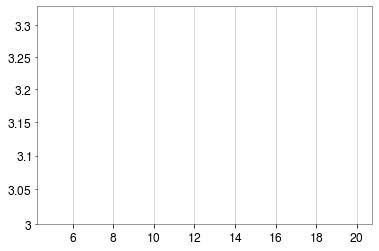

In [655]:
temp = get_temp(54)
temp.plot()
plt.show()


print('horizon distance  = ', 10**horizon(temp.highpass_fir(flow, order).lowpass_fir(fhigh, order), strain), ' Mpc')

times = [0,2,4,5]
    
Dh_band = []
Dh_win = []

    
for t in times:
        
    Temp = temp.copy().time_slice(t, 20-t).highpass_fir(flow, order).lowpass_fir(fhigh, order)
        
    snr = SNR(Temp, strain2, time=None).time_slice(5,20)
    
    print(max(snr))
    snr.plot(alpha=0.5)
        
    #Temp = temp.copy().time_slice(t, 20-t)
    #Temp *= tukey(len(Temp), 0.5)
plt.yscale('log')
plt.ylim(bottom=3)
plt.show()

for t in times:
        
    Temp = temp.copy().time_slice(t, 20-t).highpass_fir(flow, order).lowpass_fir(fhigh, order)
        
    snr = SNR(Temp, strain2, time=None, ret='new').time_slice(5,20)
    
    print(max(snr))
    snr.plot(alpha=0.5)
        
    #Temp = temp.copy().time_slice(t, 20-t)
    #Temp *= tukey(len(Temp), 0.5)
plt.yscale('log')
plt.ylim(bottom=3)